In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mp
import numpy as np
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [10]:
WEEKLY_INCENTIVE = 384615384615384615384615
WEEKLY_BLOCK_NUMBER = 44800
TOTAL_INCENTIVE = 5000000
TOTAL_CLAIM_PERIOD = 13

startBlock = 12141500

distributionBlocks = [startBlock + i* WEEKLY_BLOCK_NUMBER for i in range(TOTAL_CLAIM_PERIOD+1)]

In [11]:
df = pd.read_pickle("data/dataFrame.json")
total_by_week = pd.read_pickle("data/total_by_week.json")
total = pd.read_pickle("data/total.json")
index = df.index
i = index[0]

In [12]:
def get_reinvestment(x, balance, claimed):
#     inv = [0] * len(balance)
#     for i in range(len(balance)-1):
#         if balance[i+1]>balance[i]:
#             inv[i] = claimed[i]
    inv = [(claimed[i] if balance[i+1]>balance[i] else 0) for i in range(len(balance)-1)]
    inv_x = [([x[i]+0.5, x[i]+0.5] if balance[i+1]>balance[i] and claimed[i]>0 else 0) for i in range(len(balance)-1)]
    inv_y = [([balance[i], balance[i]+inv[i]] if balance[i+1]>balance[i] and claimed[i]>0 else 0) for i in range(len(balance)-1)]
    return inv_x, inv_y

In [13]:
df.loc[i,'reward_1']

9.429337157441772e+19

In [14]:
def draw_account(id, currency):
    fig, (ax1, ax2) = plt.subplots(2, figsize=(16,16))
    width = 0.33
    
    x = np.arange(14)
    ax1.set_xticks(x)
    ax1.set_xticklabels(x)
    
    claimed = [df.loc[id, f"claimed_{i}"] for i in range(0, 14)]
    rewards = [df.loc[id, f"reward_{i}"] for i in range(0, 14)]
    rewards_new = [0]+[max(0,rewards[i] - rewards[i-1] + claimed[i-1]) for i in range(1,14) ]
    rewards_old = [max(0,rewards[i] - rewards_new[i]) for i in range(14)]
    
    plot_rew_old = ax1.bar(x=x-width/2, height=rewards_old, width=width, color='#414141')
    plot_rew_new = ax1.bar(x=x-width/2, bottom=rewards_old, height=rewards_new, width=width, color='#414190')
    plot_claimed = ax1.bar(x=x+width/2, height=claimed, width=width, color='orange')
    
    ax1.ticklabel_format(style='sci',scilimits=(18,18),axis='y')
#     ax1.minorticks_on()
#     ax1.tick_params(axis='x', which='minor', length=0)
    ax1.grid(b=True, which='major', axis='y')
    ax1.set_axisbelow(True)
    
    ax1.legend((plot_rew_old, plot_rew_new, plot_claimed), ("Available rewards (total)", "Available rewards (new this week)", "Claimed rewards"))
    ax1.set_xlabel('Week')
    ax1.set_ylabel('HOPR Tokens')
    
    # --- 2nd Diagram ---
    balance = [df.loc[id, f"balance_{i}"] for i in range(0,14)]
    elig_balance = [df.loc[id, f"eligible_balance_{i}"] for i in range(0,13)]
    elig_balance += [0]
    
    inv_x, inv_y = get_reinvestment(x, balance, claimed)
    
    ax2.set_xticks(x)
    ax2.set_xticklabels(x)
    
    plot_bal = ax2.bar(x=x-width/2, height=balance, width=width, color='#414141')
    plot_elig = ax2.bar(x=x+width/2, height=elig_balance, width=width)
    
    for i,(x,y) in enumerate(zip(inv_x, inv_y)):
        if not x == 0:
            ax2.plot(x,y, color='orange', marker='o', linewidth=4)
    
    ax2.ticklabel_format(style='sci',scilimits=(18,18),axis='y')
#     ax2.minorticks_on()
#     ax2.tick_params(axis='x', which='minor', length=0)
    ax2.grid(b=True, which='major', axis='y')
    ax2.set_axisbelow(True)
    
    ax2.legend((plot_bal, plot_elig), ("Balance (at start of week)", "Eligible balance (lowest level during week)"))
    ax2.set_xlabel('Week')
    ax2.set_ylabel('HOPR Tokens')
    
    plt.show()


In [15]:
id = widgets.Select(
    options=[(str(i),i) for i in index],
#     value=(str(index[0]),0),
    rows=10,
    description='Account Key',
    disabled=False,
    layout={'width': 'max-content'}
)
currency = widgets.RadioButtons(
    options=['HOPR', 'ETH', 'DOLLAR'],
    description = 'Currency',
    disabled=False,
    layout={'width': 'max-content'}
)

input = widgets.HBox([id, currency])
out = widgets.interactive_output(draw_account, {'id': id, 'currency': currency})
display(input, out)
# interact(draw_account, id=[(str(i), i) for i in index])

Output()

/var/folders/43/jq8rlbj172x02r26rfm_647w0000gn/T/ipykernel_42032/2795791456.py:13: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='major', axis='both')


Text(0.5, 1.0, 'HOPR Pool')

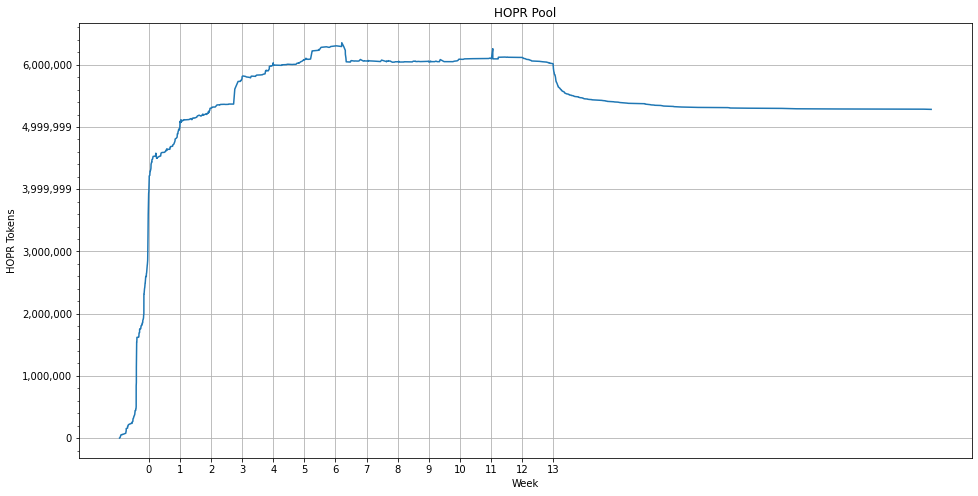

In [16]:
fig, ax = plt.subplots(figsize=(16,8))

# TODO TODO TODO
ax.set_xticks(distributionBlocks)
ax.set_xticklabels([i for i in range(14)])

ax.plot(total['block'].tolist(), total['balance'].tolist())
ax.ticklabel_format(axis = 'y', style='sci', scilimits=(18,18))
ax.get_yaxis().set_major_formatter(
    mp.ticker.FuncFormatter(lambda x, p: format(int(int(x)/(1e18)), ',')))
ax.minorticks_on()
ax.tick_params(axis='x', which='minor', length=0)
ax.grid(b=True, which='major', axis='both')
ax.set_axisbelow(True)

ax.set_xlabel('Week')
ax.set_ylabel('HOPR Tokens')

ax.set_title('HOPR Pool')
